# TUMOR ground station data display

This code is a part of the ground station segment for [TEK5720](https://www.uio.no/studier/emner/matnat/its/TEK5720/) TUMOR (Targeting Ultraviolet Mid-Ozone layer Radiation) mission

Group Blip-Blop:
* Joachim Thomle Karlsen
* Tobias Mellum
* Michał Jan Odorczuk
* Vytenis Orlauskis
* Yawar Seraj

Code made by Michał Jan Odorczuk

This code displays the newest set of data retreived from the ground station module

Ground station module code is available [here](https://github.com/VytenisO/tumor/blob/main/flightVersion/groundStation.ino)

Ground station receives data transmitted by the [CanSat module](https://github.com/VytenisO/tumor/blob/main/flightVersion/cansat.ino)

Ground station data is saved to a file with the [data capture script](https://github.com/VytenisO/tumor/blob/main/flightVersion/data_capture.ipynb)

## imports

Please install [pyserial](https://pypi.org/project/pyserial/), [matplotlib](https://pypi.org/project/matplotlib/) and [pandas](https://pypi.org/project/pandas/)

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from os import listdir, path
import numpy as np

## Parameters

In [3]:
N_UV = 4
N_displayed = 100
UV_MAX = 5000

## Plotting functions

In [4]:
def plot_uv(axes, df, i):
    uv = pd.to_numeric(df[f'UV_{i}']).to_numpy()
    al = pd.to_numeric(df[f'AL_{i}']).to_numpy()
    times = pd.to_datetime(df[f'time_{i}'], format='%H:%M:%S.%f')
    axes[0, 0].plot(times[-N_displayed:], uv[-N_displayed:], label=f'$UV_{i}$')
    axes[0, 1].plot(times[-N_displayed:], al[-N_displayed:], label=f"$AL_{i}$")

In [5]:
def plot_magnetometer(ax, df):
    mxs, mys, mzs, times = [], [], [], []
    for i in range(N_UV):
        mxs.append(pd.to_numeric(df[f'Mx_{i}']).to_numpy())
        mys.append(pd.to_numeric(df[f'My_{i}']).to_numpy())
        mzs.append(pd.to_numeric(df[f'Mz_{i}']).to_numpy())
        times.append(pd.to_datetime(df[f'time_{i}'], format='%H:%M:%S.%f').to_numpy())
    mxs = np.array(mxs)
    mys = np.array(mys)
    mzs = np.array(mzs)
    times = np.array(times)
    M_N = mxs.shape[0] * mxs.shape[1]
    mxs = np.reshape(mxs.T, M_N)
    mys = np.reshape(mys.T, M_N)
    mzs = np.reshape(mzs.T, M_N)
    times = np.reshape(times.T, M_N)
    ax.plot(times[-4 * N_displayed:], mxs[-4 * N_displayed:], label="$M_x$", color='r')
    ax.plot(times[-4 * N_displayed:], mys[-4 * N_displayed:], label="$M_y$", color='g')
    ax.plot(times[-4 * N_displayed:], mzs[-4 * N_displayed:], label="$M_z$", color='b')

In [6]:
def plot_times(ax, df):
    uv_times = []
    for i in range(N_UV):
        uv_times.append(pd.to_datetime(df[f'time_{i}'], format='%H:%M:%S.%f').to_numpy()[-N_displayed:])
        ax.plot(uv_times[i], label=f'$time_{{uv,{i}}}$')
    times = pd.to_datetime(df[f'time_GPS'], format='%H:%M:%S').to_numpy()[-N_displayed:]
    ax.plot(times, label='GPS time')

In [7]:
def plot_altitudes(ax, df):
    alts = pd.to_numeric(df['alt'])
    times = pd.to_datetime(df[f'time_0'], format='%H:%M:%S.%f')
    ax.plot(times[-N_displayed:], alts[-N_displayed:], label='GPS altitude')
    alt_bars = pd.to_numeric(df['altitude'])
    ax.plot(times[-N_displayed:], alt_bars[-N_displayed:], label='barometric altitude')

In [8]:
def plot_temperature(ax, df):
    temperatures = pd.to_numeric(df['temperature'])
    times = pd.to_datetime(df[f'time_0'], format='%H:%M:%S.%f')
    ax.plot(times[-N_displayed:], temperatures[-N_displayed:])

## Load from file and display

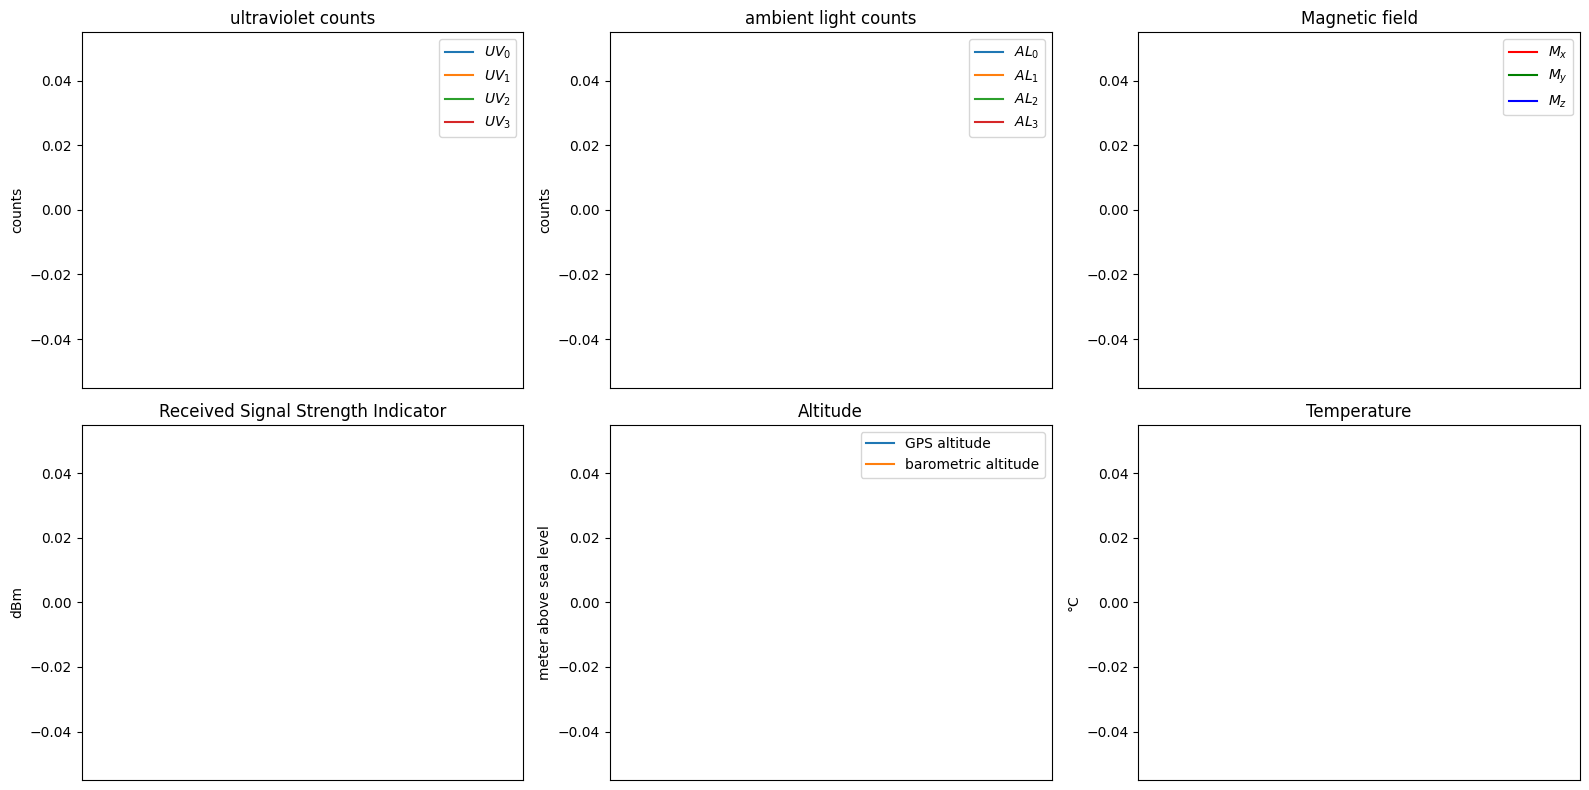

In [9]:
file_times = [(f, path.getmtime(f)) for f in listdir('.') if path.isfile(f) and f[-3:] == 'csv']

sorted_files = sorted(file_times, key=lambda x: x[1], reverse=True)
data_source = sorted_files[0][0]

while True:
    df = pd.read_csv(data_source, comment='#')
    for i in range(N_UV):
        df.loc[df[f'UV_{i}']>UV_MAX,f'UV_{i}'] = UV_MAX
    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

    axes[0, 0].set_title('ultraviolet counts')
    axes[0, 1].set_title('ambient light counts')
    axes[0, 0].set_xticks([])
    axes[0, 0].set_ylabel('counts')
    axes[0, 1].set_xticks([])
    axes[0, 1].set_ylabel('counts')
    for i in range(N_UV):
        plot_uv(axes, df, i)

    plot_magnetometer(axes[0, 2], df)
    axes[0, 2].set_title('Magnetic field')
    axes[0, 2].set_xticks([])


    # lons = pd.to_numeric(df['lon_deg']) + pd.to_numeric(df['lon_min']) / 60 + pd.to_numeric(df['lon_sec']) / 3600
    # lats = pd.to_numeric(df['lat_deg']) + pd.to_numeric(df['lat_min']) / 60 + pd.to_numeric(df['lat_sec']) / 3600
    # axes[1, 0].plot(lons[-N_displayed:], lats[-N_displayed:])
    # axes[1, 0].scatter(lons[-1:], lats[-1:], c='r')
    # axes[1, 0].set_title('Coordinates')
    # axes[1, 0].set_xlabel('°E')
    # axes[1, 0].set_ylabel('°N')
    # plot_times(axes[1, 0], df)
    axes[1, 0].set_title('Received Signal Strength Indicator')
    rssi = pd.to_numeric(df['RSSI'])
    times = pd.to_datetime(df[f'time_0'], format='%H:%M:%S.%f')
    axes[1, 0].plot(times[-N_displayed:], rssi[-N_displayed:])
    axes[1, 0].set_xticks([])
    axes[1, 0].set_ylabel('dBm')

    plot_altitudes(axes[1, 1], df)
    axes[1, 1].set_title('Altitude')
    axes[1, 1].set_xticks([])
    axes[1, 1].set_ylabel('meter above sea level')

    plot_temperature(axes[1, 2], df)
    axes[1, 2].set_title('Temperature')
    axes[1, 2].set_xticks([])
    axes[1, 2].set_ylabel('°C')

    # Adjust layout for better appearance
    plt.tight_layout()
    clear_output(wait=True)
    # Display the subplots
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 2].legend()
    # axes[1, 0].legend()
    axes[1, 1].legend()
    plt.show()


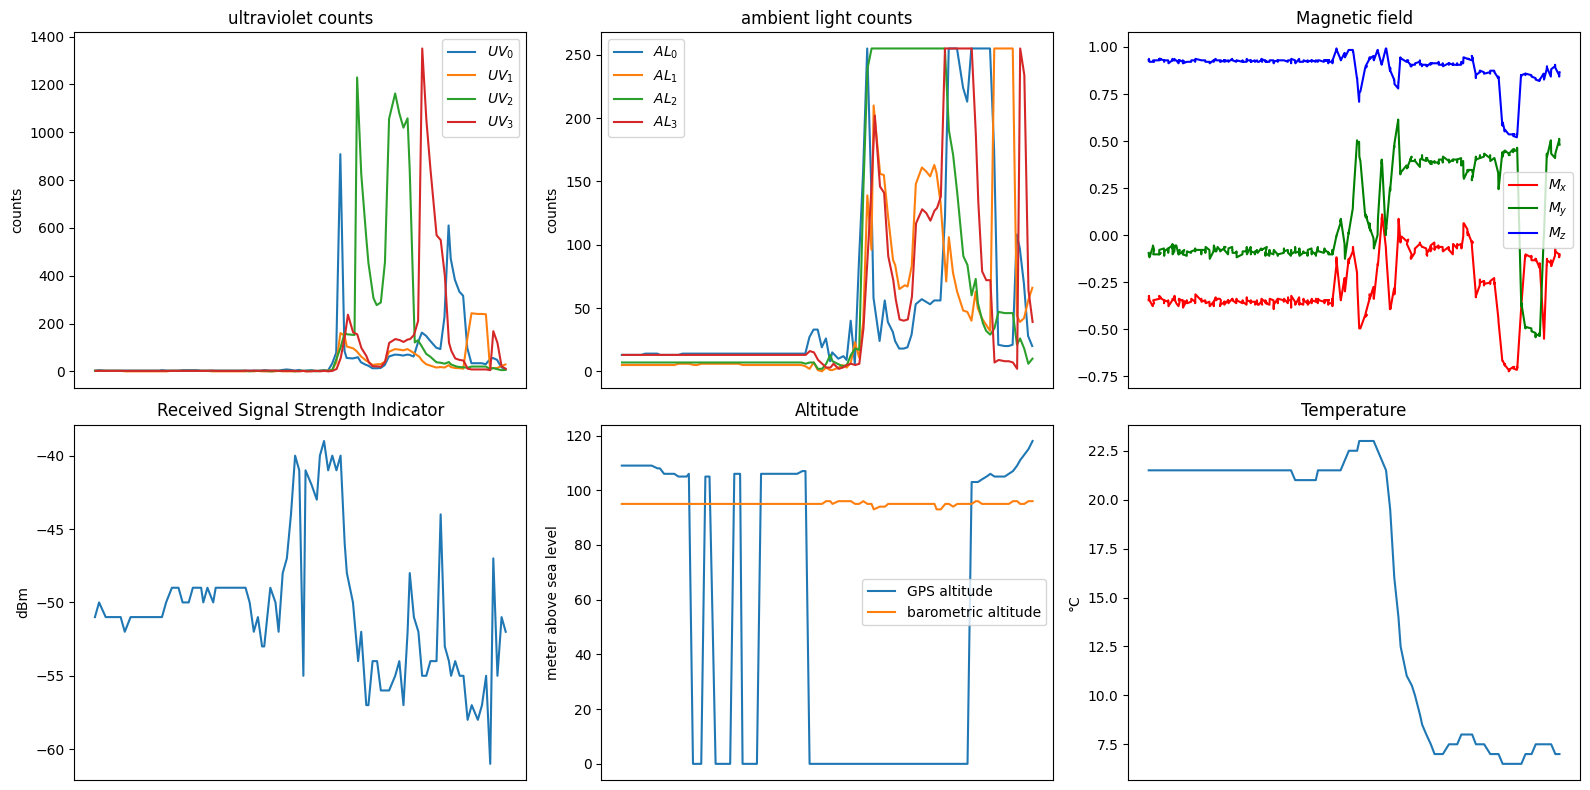

In [ ]:
file_times = [(f, path.getmtime(f)) for f in listdir('.') if path.isfile(f) and f[-3:] == 'csv']

sorted_files = sorted(file_times, key=lambda x: x[1], reverse=True)
data_source = sorted_files[0][0]

while True:
    df = pd.read_csv(data_source, comment='#')
    for i in range(N_UV):
        df.loc[df[f'UV_{i}']>UV_MAX,f'UV_{i}'] = UV_MAX
    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

    axes[0, 0].set_title('ultraviolet counts')
    axes[0, 1].set_title('ambient light counts')
    axes[0, 0].set_xticks([])
    axes[0, 0].set_ylabel('counts')
    axes[0, 1].set_xticks([])
    axes[0, 1].set_ylabel('counts')
    for i in range(N_UV):
        plot_uv(axes, df, i)

    plot_magnetometer(axes[0, 2], df)
    axes[0, 2].set_title('Magnetic field')
    axes[0, 2].set_xticks([])


    # lons = pd.to_numeric(df['lon_deg']) + pd.to_numeric(df['lon_min']) / 60 + pd.to_numeric(df['lon_sec']) / 3600
    # lats = pd.to_numeric(df['lat_deg']) + pd.to_numeric(df['lat_min']) / 60 + pd.to_numeric(df['lat_sec']) / 3600
    # axes[1, 0].plot(lons[-N_displayed:], lats[-N_displayed:])
    # axes[1, 0].scatter(lons[-1:], lats[-1:], c='r')
    # axes[1, 0].set_title('Coordinates')
    # axes[1, 0].set_xlabel('°E')
    # axes[1, 0].set_ylabel('°N')
    # plot_times(axes[1, 0], df)
    axes[1, 0].set_title('Received Signal Strength Indicator')
    rssi = pd.to_numeric(df['RSSI'])
    times = pd.to_datetime(df[f'time_0'], format='%H:%M:%S.%f')
    axes[1, 0].plot(times[-N_displayed:], rssi[-N_displayed:])
    axes[1, 0].set_xticks([])
    axes[1, 0].set_ylabel('dBm')

    plot_altitudes(axes[1, 1], df)
    axes[1, 1].set_title('Altitude')
    axes[1, 1].set_xticks([])
    axes[1, 1].set_ylabel('meter above sea level')

    plot_temperature(axes[1, 2], df)
    axes[1, 2].set_title('Temperature')
    axes[1, 2].set_xticks([])
    axes[1, 2].set_ylabel('°C')

    # Adjust layout for better appearance
    plt.tight_layout()
    clear_output(wait=True)
    # Display the subplots
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 2].legend()
    # axes[1, 0].legend()
    axes[1, 1].legend()
    plt.show()
